# Linear Reconstruction Attack on LCF and Noise
# Part I: Simple Constraints

This notebook looks at the effectiveness of a simple linear reconstruction attack on Low Count Filtering (LCF) and noise addition (Gaussian). Other notebooks may look at more sophisticated attacks. The formulation of the constraints of the LP problem is described in Appendix A at the bottom of this notebook. Appendix B contains a description of the experimental variables.

First gather the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import sys
stdout = sys.stdout
import os
filePath = globals()['_dh'][0]
parDir = os.path.abspath(os.path.join(filePath, os.pardir))
print(parDir)
sys.path.append(parDir)
import tools.results

rg = tools.results.resultGatherer(attackType='random')
dfAll,dfAgg = rg.gatherResults()


c:\paul\GitHub\attacker\diffixElmPaperAttacks


First let's look at the first few rows of data. Columns starting with `a_` are the anonymization paramaters. Those with `t_` are the table parameters, and with `v_` are the solver parameters. Those with `s_` are the solution results. Appendix B contains a description of the experimental parameters and results.

In [2]:

display(dfAll.head())

,seed,s_cr,s_c,s_ci,s_tim,s_choi,s_cons,s_sol,a_gap,a_lab,...,a_sds,a_sd,v_lcf,v_nse,v_nsds,t_alen,t_atkr,t_aids,t_sym,t_freq
0,000,0.0,0.0,0.000000,0.40,200,1455,1,2,P,...,1.0,1.0607,1.0,1.0,4.0,120,trusted,100,2,0.1
1,000,0.0,0.0,0.000000,0.31,200,1459,1,2,P,...,1.0,1.0607,1.0,1.0,5.0,120,trusted,100,2,0.1
2,000,1.0,0.5,0.444444,0.35,200,1259,1,2,P,...,1.0,1.0607,1.0,1.0,4.0,120,trusted,100,2,0.1
3,000,1.0,0.4,0.333333,0.32,200,1059,1,2,P,...,1.0,1.0607,1.0,1.0,4.0,120,trusted,100,2,0.1
4,000,0.0,0.0,0.000000,0.32,200,1455,1,3,XP,...,1.5,1.5910,1.0,1.0,4.0,120,trusted,100,2,0.1


Some of these columns are just statistics about the solver itself, so let's make a dataframe with just the columns related to anonymization.

In [3]:
df = dfAll[['s_sol','s_c','s_cr','s_ci','a_lab','a_sd','a_pri','v_lcf','v_nse','v_nsds','t_sym','t_aids','t_alen','t_freq','t_atkr']]

In [4]:
df.describe(include='all')

,s_sol,s_c,s_cr,s_ci,a_lab,a_sd,a_pri,v_lcf,v_nse,v_nsds,t_sym,t_aids,t_alen,t_freq,t_atkr
count,5747.0,5747.000000,5747.000000,5747.000000,5747,5747.000000,5747,5747.0,5747.0,5747.000000,5747.000000,5747.000000,5747.000000,5747.000000,5747
unique,NaN,NaN,NaN,NaN,4,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,P,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trusted
freq,NaN,NaN,NaN,NaN,1912,NaN,2291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2938
mean,1.0,0.329550,0.831390,0.107859,NaN,1.587955,NaN,1.0,1.0,3.316687,13.852793,134.057769,119.295284,0.304559,NaN
std,0.0,0.349000,0.374439,0.457278,NaN,0.438165,NaN,0.0,0.0,0.581599,12.852475,196.998966,13.904452,0.199965,NaN
min,1.0,0.000000,0.000000,-1.000000,NaN,0.000000,NaN,1.0,1.0,3.000000,2.000000,10.000000,15.000000,0.100000,NaN
25%,1.0,0.000000,1.000000,-0.036062,NaN,1.060700,NaN,1.0,1.0,3.000000,2.000000,10.000000,120.000000,0.100000,NaN
50%,1.0,0.175000,1.000000,0.000000,NaN,1.591000,NaN,1.0,1.0,3.000000,8.000000,50.000000,120.000000,0.500000,NaN
75%,1.0,0.571429,1.000000,0.259259,NaN,2.121300,NaN,1.0,1.0,4.000000,32.000000,100.000000,120.000000,0.500000,NaN


## Validate perfect reconstruction

There is a set of experiments with no anonymization at all that should have perfect reconstruction (`a_lab='None'`). This serves to partially validate the solver.

In [5]:
dfPerfect = dfAll.query('a_lab == "None"')
dfPerfect.describe()

,s_cr,s_c,s_ci,s_tim,s_choi,s_cons,s_sol,a_gap,a_low,a_sds,a_sd,v_lcf,v_nse,v_nsds,t_alen,t_aids,t_sym,t_freq
count,11.0,11.0,11.0,11.00000,11.000000,11.000000,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.000000,11.000000,11.0
mean,1.0,1.0,1.0,0.68000,92.727273,698.818182,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,120.0,46.363636,2.545455,0.5
std,0.0,0.0,0.0,0.13914,24.120908,563.223192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.060454,1.809068,0.0
min,1.0,1.0,1.0,0.46000,20.000000,529.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,120.0,10.000000,2.000000,0.5
25%,1.0,1.0,1.0,0.60500,100.000000,529.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,120.0,50.000000,2.000000,0.5
50%,1.0,1.0,1.0,0.66000,100.000000,529.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,120.0,50.000000,2.000000,0.5
75%,1.0,1.0,1.0,0.74500,100.000000,529.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,120.0,50.000000,2.000000,0.5
max,1.0,1.0,1.0,0.96000,100.000000,2397.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,120.0,50.000000,8.000000,0.5


The above shows perfect reconstruction. So after this I'm going to ignore that data. Also let's make three data sets, one each for the three prior knowledge settings ('none' for no prior knowledge, 'half' for knowing half of the rows, 'all-but-one' for knowing every row except one).

In [6]:
dfTemp = dfAll.query("a_lab != 'None'")
dfTemp = dfTemp.query("a_pri != 'all'")
dfNone = dfTemp.query("a_pri == 'none'")
dfHalf = dfTemp.query("a_pri == 'half'")
dfNear = dfTemp.query("a_pri == 'all-but-one'")

## Effect of random seed

The following graphs explore the variation in individual solution runs. The data is for the same size of graph (three columns with three values each), but for 25 separate runs each with a different random seed.

In [7]:
display(dfNone[['a_lab','a_low','a_sds','a_gap','a_sd']].drop_duplicates().sort_values(by=['a_sd']))

,a_lab,a_low,a_sds,a_gap,a_sd
3,P,2,1.0,2,1.0607
7,XP,2,1.5,3,1.5910
11,XXP,2,2.0,4,2.1213


The above shows the parameter settings for the different labels `a_lab`.  'P' means 'private', 'XP' means 'extra private', and 'XXP' means 'extra extra private'.

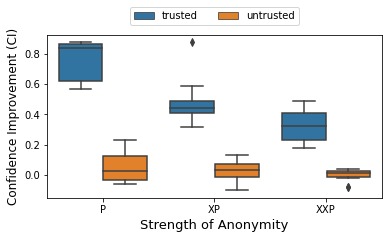

In [8]:
dfTemp = dfNone.query('t_sym == 8 and t_aids == 100 and t_freq == 0.5')
plt.figure(figsize=(6, 3))
ax = sns.boxplot(x='a_lab',y='s_ci',data=dfTemp,hue='t_atkr')
plt.xlabel('Strength of Anonymity',fontsize=13)
plt.ylabel('Confidence Improvement (CI)',fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)

The above box plots are for individual (differently-seeded) experiments. This shows that there is substantial zzzz

In [9]:
dfTemp = dfAgg.query("a_lab != 'None'")
dfTemp = dfTemp.query("a_pri != 'all'")
dfAggNone = dfTemp.query("a_pri == 'none'")
dfAggHalf = dfTemp.query("a_pri == 'half'")
dfAggNear = dfTemp.query("a_pri == 'all-but-one'")

display(dfAggNone.head())

,num,s_cr_av,s_cr_mn,s_cr_mx,s_cr_sd,s_c_av,s_c_mn,s_c_mx,s_c_sd,s_ci_av,...,v_nse,v_nsds_av,v_nsds_mn,v_nsds_mx,v_nsds_sd,t_alen,t_atkr,t_aids,t_sym,t_freq
3,10,1.0,1.0,1.0,0.0,0.650000,0.400000,0.900000,0.191233,0.611111,...,1.0,3.9,3.0,4.0,0.316228,120,trusted,100,2,0.1
7,10,1.0,1.0,1.0,0.0,0.584545,0.272727,0.800000,0.188759,0.538384,...,1.0,3.3,3.0,4.0,0.483046,120,trusted,100,2,0.1
11,10,1.0,1.0,1.0,0.0,0.231212,0.100000,0.363636,0.077942,0.145791,...,1.0,3.0,3.0,3.0,0.000000,120,trusted,100,2,0.1
15,10,1.0,1.0,1.0,0.0,0.851582,0.780000,0.900000,0.041775,0.703164,...,1.0,4.0,4.0,4.0,0.000000,120,trusted,100,2,0.5
19,10,1.0,1.0,1.0,0.0,0.695506,0.580000,0.775510,0.058768,0.391012,...,1.0,4.0,4.0,4.0,0.000000,120,trusted,100,2,0.5


In [10]:
print(dfNone[['v_nsds','seed']].groupby(by='v_nsds').count())

        seed
v_nsds      
3.0     1626
4.0      591
5.0       56
7.0        7


The above tells us how many of the problems were solved with different values of `v_nsds`. This is the number of standard deviations plus or minus the noisy count within which the solver can assign a count. The smaller the `v_nsds`, the more accurate the solution and so the better the reconstruction.

## Attacks in U-Mode (Untrusted)

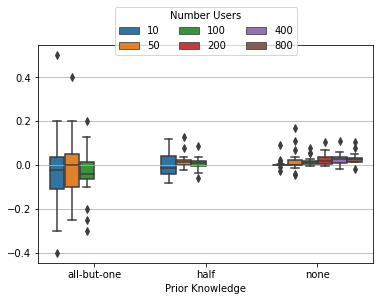

In [11]:
df2 = dfAgg.query('t_atkr == "untrusted" and a_pri != "all" and a_lab != "None"')
ax2 = sns.boxplot(x='a_pri',y='s_ci_av',data=df2,hue='t_aids')
ax2.set(ylabel = '', xlabel='Prior Knowledge')
ax2.grid(axis='y')
ax2.legend(title='Number Users',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)

The above tells us that in any event having some prior knowledge doesn't really help the attacker. The median behavior is roughly the same, and the attacker doesn't know which attacks have better CI. So from now we can focus only on the case of no prior knowledge ('none').

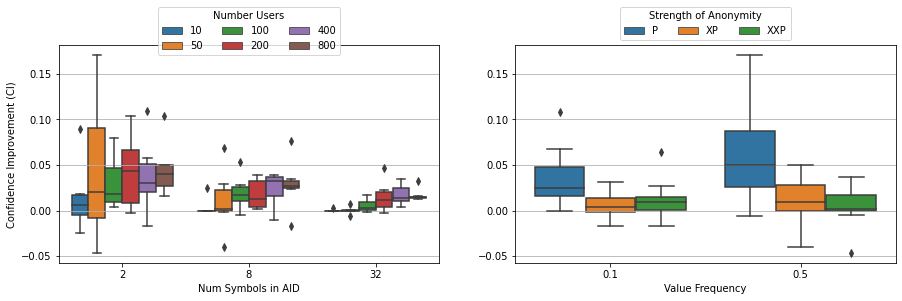

In [12]:
df1 = dfAggNone.query('t_atkr == "untrusted"')
fig, axes = plt.subplots(1,2,figsize=(15,4))
ax1 = sns.boxplot(x='t_sym',y='s_ci_av',data=df1,hue='t_aids',ax=axes[0])
ax2 = sns.boxplot(x='t_freq',y='s_ci_av',data=df1,hue='a_lab',ax=axes[1])
ax1.set(ylabel = 'Confidence Improvement (CI)', xlabel='Num Symbols in AID')
ax2.set(ylabel = '', xlabel='Value Frequency')
#ax1.set(ylim=(0, 1))
#ax2.set(ylim=(0, 1))
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.legend(title='Number Users',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax2.legend(title='Strength of Anonymity',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)


The above two plots tell us a number of things. First and foremost, the attack (in U-Mode) is not effective. The median score has CI barely above zero. Fewer symbols in the AIDs help a little but not much. Attacking more users helps only a little. Weaker anonymiztion strength helps only a little. Attacking a more frequent value helps only a little.

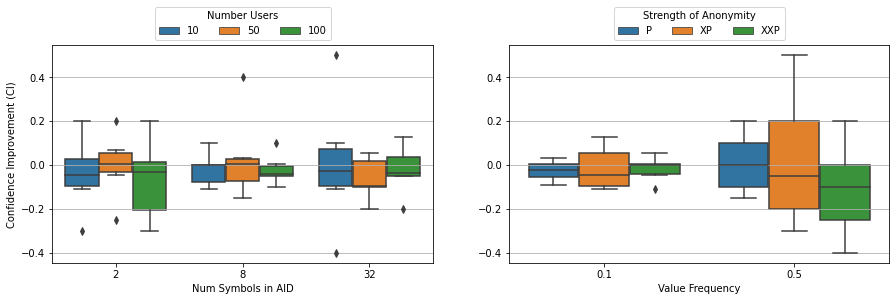

In [13]:

df1 = dfAggNear.query('t_atkr == "untrusted"')
fig, axes = plt.subplots(1,2,figsize=(15,4))
ax1 = sns.boxplot(x='t_sym',y='s_ci_av',data=df1,hue='t_aids',ax=axes[0])
ax2 = sns.boxplot(x='t_freq',y='s_ci_av',data=df1,hue='a_lab',ax=axes[1])
ax1.set(ylabel = 'Confidence Improvement (CI)', xlabel='Num Symbols in AID')
ax2.set(ylabel = '', xlabel='Value Frequency')
#ax1.set(ylim=(0, 1))
#ax2.set(ylim=(0, 1))
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.legend(title='Number Users',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax2.legend(title='Strength of Anonymity',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)


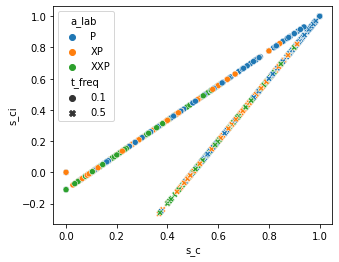

In [14]:
fig, axes = plt.subplots(1,1,figsize=(5,4))
ax = sns.scatterplot(data=dfNone, x="s_c", y="s_ci",hue='a_lab',style='t_freq')

The above plot (confidence improvement against confidence) simply confirms that CI is a constant factor (0.5 or 0.1 depend on the value frequency) of C.

## Trusted Mode

Now let's look at the attack effectiveness in trusted mode. IMPORTANT: because trusted mode, we assume that an analyst won't accidently make the set of queries required. Never-the-less we should know.

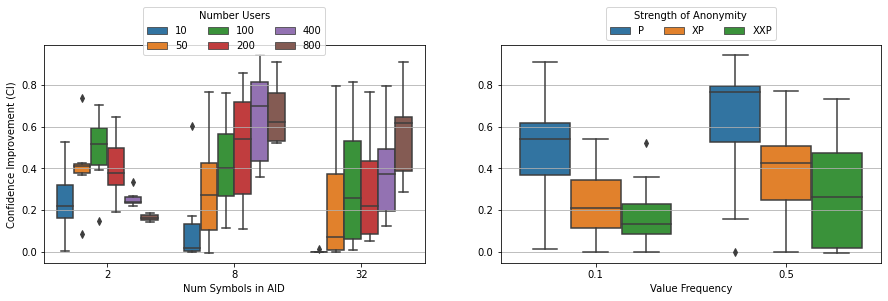

In [15]:
df1 = dfAggNone.query('t_atkr == "trusted"')
fig, axes = plt.subplots(1,2,figsize=(15,4))
ax1 = sns.boxplot(x='t_sym',y='s_ci_av',data=df1,hue='t_aids',ax=axes[0])
ax2 = sns.boxplot(x='t_freq',y='s_ci_av',data=df1,hue='a_lab',ax=axes[1])
ax1.set(ylabel = 'Confidence Improvement (CI)', xlabel='Num Symbols in AID')
ax2.set(ylabel = '', xlabel='Value Frequency')
#ax1.set(ylim=(0, 1))
#ax2.set(ylim=(0, 1))
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.legend(title='Number Users',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax2.legend(title='Strength of Anonymity',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)

The above plots show the effectiveness of a malaicious attack while in trusted mode. Contrary to untrusted mode, the attacker can reach very good CI. The two plots show the effect of various experimental parameters.

Each whisker bar in the above plots gives CI over a range of experimental parameters while holding two such parameters constant. For instance, the left-most whisker bar shows the results where the number of symbols in the AID is 2 and there are 10 users being attacked, while the other parameters (strength of anonymity and value frequency) vary. The idea here is simply to show the overall effect of each parameter.

On the left, we see that the attacker can in general improve CI by attacking more users, but how many users depends on the number of symbols per character in the AID. (Two symbols would be an AID like '01101011', 8 symbols would be like '04726625'.) Note, however, that in this attack the substring width was always 1, so with 2 symbols the attacker could mimic 8 symbols by increasing the substring width to 3.

On the right, we see that stronger anonymity (more noise, higher suppression threshold) leads to lower CI, but in any event the attacker can get very high and even perfect CI under some attack conditions.

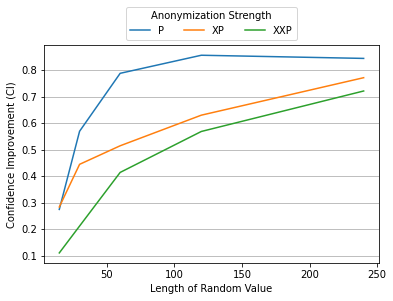

In [16]:
df1 = dfAggNone.query('t_atkr == "trusted" and t_aids == 200 and t_sym == 8 and t_freq == 0.5')
fig, axes = plt.subplots(1,1,figsize=(6,4))
ax1 = sns.lineplot(x='t_alen',y='s_ci_av',data=df1,hue='a_lab')
ax1.set(ylabel = 'Confidence Improvement (CI)', xlabel='Length of Random Value')
ax1.legend(title='Anonymization Strength',loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax1.grid(axis='y')

The above graph shows CI at each anonymization strength for different lengths of the random value. The longer the value, the more randomness is available to the attacker, and so the better the CI. Note that the length of random value here would be for all columns with randomness, not just one. So if there are two columns with random values of length 10 each, this would be identical to one column of length 20. 

The above graph has 200 attacked users, a value frequency of 0.5, and 8 symbols per random value character (these are relatively good conditions for the attacker). We see that when there are relatively few characters in the random value, the attack is not effective. In other words, if the data has little or no randomness, then this attack is not possible.

## Appendix A: Operation of Basic Linear Reconstruction Attack

This attack is similar to the original Nissim attack from 2003. It assumes knowledge of the set of random values representing the individuals being attacked (`random_col`). The attacker wants to learn the value attributed to each user from another column (`unknown_col`).  We also assume that the LR attacker knows the anonymizer parameters (LCF bounds and noise SD). Finally, we assume the attacker knows the possible set of values in `random_col` so that the attacker knows when suppression has taken place.

Each query requests the count of distinct AIDs, and returns either a noisy count or a suppression indication. Constraints are generated from these answers.

A typical query (here for two column dimensions) is:

```
SELECT SUBSTRING(random_col,1,3), unknown_col, count(DISTINCT aid)
FROM table
GROUP BY 1,2
```

This query returns zero or more buckets with noisy counts. Because the attacker knows the values of `random_col`, the attacker also knows which users are in the set of buckets for all values of `unknown_col` taken together.

For instance, suppose that `random_col` consists of the characters a and b, and that `unknown_col` consists of the values y and z. Then the answer to the above query may look like:

| random | unknown | count |
| --- | --- | ---
| a | y | 33 |
| a | z | 3 |
| b | y | 42 |

The attacker know which users have random values a and b (in the third character position of `random_col`), but not which `unknown_col` values are assigned to each user. The attacker also knows in this case that the bucket for a|z has been suppressed.

The attacker creates a set of two variables per user, one representing the user having unknown value y, and one representing the user having unknown value z. There is one such variable per user per possible unknown value. Each of the variables is binary, and so can take on either value 0 (False) or 1 (True).

With multiple outputs like this, the attacker generates a set of constraints:

1. The sum of each users' variables is 1. (The user has either value y or value z, not both.)
2. For all users in a given unsuppressed bucket, the sum of the associated variables is in a range above and below the noisy count (we use 2 standard deviations).
3. For all users in a suppressed bucket, the sum of the associated variables is in a range from `low_count` (the lowest possible value) to 2 standard deviations above the mean suppression threshold.

The attacker then solves for these constraints.

## Appendix B: Column Definitions

In [17]:
display(dfAll.columns)

Index(['seed', 's_cr', 's_c', 's_ci', 's_tim', 's_choi', 's_cons', 's_sol',
       'a_gap', 'a_lab', 'a_low', 'a_pri', 'a_sds', 'a_sd', 'v_lcf', 'v_nse',
       'v_nsds', 't_alen', 't_atkr', 't_aids', 't_sym', 't_freq'],
      dtype='object')

Above are the columns in the experiment data. They are described below.

### General experimental Parameters
* *t_alen*: The number of characters in the AID (the random column)
* *t_aids*: The number of AIDs (distinct users) being attacked
* *t_atkr*: Whether we are simulating trusted or untrusted mode
* *t_sym*: The number of symbols per character in the AID
* *t_freq*: The frequency at which the unknown variable exists in the data

### Anonymization Parameters
* *a_lab*: A label denoting anonymization strength (P, XP, or XXP, or None if no anonymization)
* *a_low*: The low threshold for suppression
* *a_gap*: The number of standard deviations between `a_low` and the mean suppression threshold
* *a_sds*: The standard deviation for the suppression threshold noise
* *a_sd*: The standard deviation of added noise.

### Solution parameters
* *v_lcf*: The fraction of the LCF threshold range that is penalty-free if elastic constraints used.
* *v_nse*: The fraction of the noise constraints range that is penalty-free if elastic constraints used.
* *v_nsds*: The number of standard deviations to use as the constraints range for noise (the constraints range is `v_nsds * a_sd`)

### Solution results
#### Solution quality measures
* *s_ci*: Confidence Improvement CI
* *s_cr*: Claim Rate CR
* *s_c*: Confidence
* *s_tim*: The length of time for the solver
* *s_sol*: Whether or not the solver found a solution (always 1)

All of the numeric parameters from the above are summarized in groups with the same experimental parameters but different seeds. Each parameter is summarized with average, min, max, and standard deviation (i.e. s_ci has s_ci_av, s_ci_mn, s_ci_mx, and s_ci_sd).


In [18]:
display(dfAgg.columns)

Index(['num', 's_cr_av', 's_cr_mn', 's_cr_mx', 's_cr_sd', 's_c_av', 's_c_mn',
       's_c_mx', 's_c_sd', 's_ci_av', 's_ci_mn', 's_ci_mx', 's_ci_sd',
       's_tim_av', 's_tim_mn', 's_tim_mx', 's_tim_sd', 's_choi_av',
       's_choi_mn', 's_choi_mx', 's_choi_sd', 's_cons_av', 's_cons_mn',
       's_cons_mx', 's_cons_sd', 's_sol_av', 's_sol_mn', 's_sol_mx',
       's_sol_sd', 'a_gap', 'a_lab', 'a_low', 'a_pri', 'a_sds', 'a_sd',
       'v_lcf', 'v_nse', 'v_nsds_av', 'v_nsds_mn', 'v_nsds_mx', 'v_nsds_sd',
       't_alen', 't_atkr', 't_aids', 't_sym', 't_freq'],
      dtype='object')